In [1]:
import sys
import os

sys.path.insert(0, './src/')

from FRAPanalyzer.lifproc import LIFContainer
from FRAPanalyzer.lifproc import start_bioformats
from FRAPanalyzer.lifproc import stop_bioformats
from pprint import pprint

from collections import OrderedDict
import numpy as np

from IPython.display import HTML

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import patches
from ipywidgets import widgets

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [36]:
%matplotlib notebook

In [2]:
start_bioformats()

BioContainer started


In [3]:
from glob import glob
mask = './test_data/06.04.2014*.lsm'
lsms = glob(mask)
lsms

['./test_data/06.04.2014 3T3 HP-Btk FRAP.lsm',
 './test_data/06.04.2014 3T3 HP-Btk FRAP1.lsm',
 './test_data/06.04.2014 3T3 HP-Btk FRAP2.lsm']

In [4]:
lif = LIFContainer(lsms[2])

In [5]:
lif.lif_img_data

OrderedDict([('06.04.2014 3T3 HP-Btk FRAP2',
              {'C': 1,
               'ID': 'Image:0',
               'T': 156,
               'X': 512,
               'Y': 512,
               'Z': 1})])

In [6]:
series_id = lif.lif_img_data.keys()[0]

In [7]:
img = lif.get_full_array(series_id, progressbar=True)

100%|██████████| 156/156 [00:09<00:00, 16.35it/s]     | 1/156 [00:00<00:49,  3.11it/s]


In [8]:
img.shape

(512, 512, 1, 156)

In [9]:
print(lif.lif_img_data[series_id])
current_series_id = lif.lif_series_order.index(series_id)

{'C': 1, 'T': 156, 'Y': 512, 'X': 512, 'Z': 1, 'ID': 'Image:0'}


In [10]:
rois_struc = lif.get_rois_from_oemxml()

In [11]:
rois_struc['ROI:0'][0]

{'RadiusX': 22.88329322836028,
 'RadiusY': 22.88329322836028,
 'X': 414.859538784067,
 'Y': 177.10691823899373,
 'type': 'Ellipse'}

In [12]:
sa = lif.get_structured_annotations()

In [13]:
{k:v for k,v in sa[series_id].items() if k.startswith('TimeInterval') or k.startswith('Event')}

#  'TimeInterval' '1.122461205037396'
#  'Event Description #1': 'Bleach start',
#  'Event Description #2': 'Bleach end',
#  'Event Time #1': '21736.273687960605',
#  'Event Time #2': '21739.89006432424',
#  'Event Type #1': '2',
#  'Event Type #2': '3',

{'Event Description #1': 'Bleach start',
 'Event Description #2': 'Bleach end',
 'Event Time #1': '21736.273687960605',
 'Event Time #2': '21739.89006432424',
 'Event Type #1': '2',
 'Event Type #2': '3',
 'TimeInterval': '1.122461205037396'}

In [ ]:
1.122461205037396*1000*np.arange(30)

In [14]:
img = img[:,:,0,:]
img.shape

(512, 512, 156)

In [ ]:
fig = plt.figure()
ax = plt.imshow(roi0_imgs[:,:,0])
def init():
    ax.set_data(np.zeros_like(roi0_imgs[:,:,0]))
    return ax,
def animate(i):
    ax.set_data(roi0_imgs[:,:,i])
    return ax,
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=roi0_imgs.shape[-1])

In [ ]:
fig = plt.figure()
ax = plt.imshow(img[:,:,0])

def init():
    ax.set_data(np.zeros_like(img[:,:,0]))
    return ax,

def animate(i):
#     print(i)    
    ax.set_data(img[:,:,i])
#     edge_roberts = roberts(image)
#     ax.set_data(roberts(img[:,:,channel,i]))
    return ax,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=img.shape[-1])#, interval=20, blit=True)

In [15]:
rois_struc.keys()

['ROI:1', 'ROI:0', 'ROI:3', 'ROI:2']

In [20]:
def circle_mask(shape,centre,radius):
    """
    Return a circle mask
    """
    x,y = np.ogrid[:shape[0],:shape[1]]
    cx,cy = centre
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy)
    return r2 <= radius*radius

In [17]:
def crop_matrix(A, padding=0):
    size = A.shape
    B = np.argwhere(A)
    (ystart, xstart), (ystop, xstop) = B.min(0), B.max(0) + 1
    ystart = max(0, ystart - padding)
    xstart = max(0, xstart - padding)
    ystop = min(ystop + padding, size[0])
    xstop = min(xstop + padding, size[1])
    return ystart,ystop,xstart,xstop

In [21]:
fig = plt.figure(figsize=(13,5))

roi_masks = [0,0,0]

shp = img[:,:,3].shape
sumofrois = np.zeros(shp)

for _id, roi in enumerate(['ROI:0', 'ROI:1', 'ROI:2']):
    RadiusX, RadiusY, X, Y = map(rois_struc[roi][0].get, ('RadiusX', 'RadiusY', 'X', 'Y'))
#     sumofrois += circle_mask(shp, (Y, X), RadiusX)
    msk = circle_mask(shp, (Y, X), RadiusX)
    ystart,ystop,xstart,xstop = roi_masks[_id] = crop_matrix(msk, padding=20)
    ax = plt.subplot(1,3,_id+1)
    ax.imshow(img[ystart:ystop,xstart:xstop,3])
    ax.set_title(roi)
#     ellipse = patches.Ellipse(xy=(X, Y), width=2*RadiusX, height=2*RadiusY, linewidth=2.0, fill=False)
#     fig.gca().add_artist(ellipse)

# plt.imshow(sumofrois)
ax.set_aspect('equal')


In [22]:
roi_masks

[(135, 220, 372, 458), (268, 340, 89, 161), (338, 495, 327, 484)]

In [23]:
yst,ystp,xst,xstp = roi_masks[0]
roi0_imgs = img[yst:ystp,xst:xstp,:]

In [24]:
from tqdm import tqdm_notebook

In [26]:
from skimage.filters import (sobel_h, sobel_v)

# horizontal / vertical
sobel_frames = (np.zeros_like(roi0_imgs), np.zeros_like(roi0_imgs))

for i in tqdm_notebook(range(roi0_imgs.shape[-1]),total=roi0_imgs.shape[-1]):
    sobel_frames[0][:,:,i] = sobel_h(roi0_imgs[:,:,i])
    sobel_frames[1][:,:,i] = sobel_v(roi0_imgs[:,:,i])

In [30]:
def win_average(arr, n=3):
    length = arr.shape[-1]
    result = np.zeros(arr.shape[:2] + (length - n + 1,))
    for i in range(length - n + 1):
        result[:,:,i] = arr[:,:,i:i+n].sum(axis=2)/n
    return result

In [31]:
average_roi_img_n3 = map(lambda ar: win_average(ar,n=5), sobel_frames)

In [33]:
shape = roi0_imgs.shape
Ymesh, Xmesh = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))

In [45]:
plt.quiverkey?

<IPython.core.display.Javascript object>


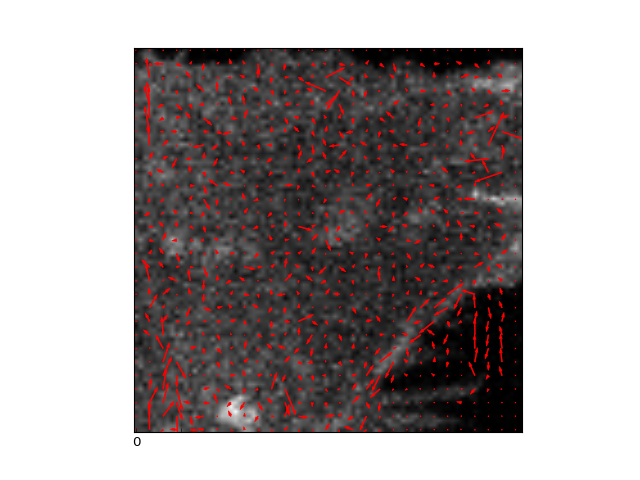

In [46]:
fig = plt.figure()
tstep = 0
V, U = average_roi_img_n3

Q = plt.quiver(Xmesh[::3, ::3], Ymesh[::3, ::3], U[::3, ::3, 0], V[::3, ::3, 0],
               color='r', units='x',
               linewidths=(0.5,), edgecolors=('r'), headaxislength=5)
# qk = plt.quiverkey(Q, 0.5, 0.03, 1, r'$1 \frac{m}{s}$', fontproperties={'weight': 'bold'})

ax = plt.imshow(roi0_imgs[:,:,0], cmap=plt.cm.gray)

def init():
    Q.set_UVC(U[::3, ::3, 0], V[::3, ::3, 0])
    ax.set_data(roi0_imgs[:,:,0])
    return Q,

def animate(i):
    Q.set_UVC(U[::3, ::3, i], V[::3, ::3, i])
    ax.set_data(roi0_imgs[:,:,i])
    return Q,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=60)#, interval=20, blit=True)


# Q = plt.quiver(Xmesh[::3, ::3], Ymesh[::3, ::3], U[::3, ::3, tstep], V[::3, ::3, tstep],
#                color='r', units='x',
#                linewidths=(0.5,), edgecolors=('k'), headaxislength=5)
# qk = plt.quiverkey(Q, 0.5, 0.03, 1, r'$1 \frac{m}{s}$', fontproperties={'weight': 'bold'})

In [ ]:
fig = plt.figure(figsize=(13,9))

image_ax = plt.imshow(img[:,:,3])

for roi in ['ROI:1', 'ROI:0', 'ROI:2']:
    RadiusX, RadiusY, X, Y = map(rois_struc[roi][0].get, ('RadiusX', 'RadiusY', 'X', 'Y'))
    ellipse = patches.Ellipse(xy=(X, Y), width=2*RadiusX, height=2*RadiusY, linewidth=2.0, fill=False)
    fig.gca().add_artist(ellipse)

ax.set_aspect('equal')

In [47]:
anim.save('quiver_with_roi.avi', fps=1, extra_args=['-vcodec', 'libx264'])

HTML(anim.to_html5_video())

In [ ]:
# cut segment after bleaching
# find countour
# apply sobol filter for S_x and S_y
# get atan(S_y/S_x)
# calculate mean for some number of frames show arrow with amplitude in points


In [ ]:
stop_bioformats()